# Train ML

> A collection of machine learning tools

In [1]:
#| default_exp train

In [2]:
#| hide
import sys
sys.path.append("/notebooks/katlas")
from nbdev.showdoc import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
#| export
# katlas
from katlas.core import Data
from katlas.feature import *

# essentials
from fastbook import *
from joblib import dump, load
import math, xgboost as xgb, matplotlib.pyplot as plt
from pathlib import Path

# scipy
from scipy.stats import spearmanr, pearsonr
from scipy.stats import spearmanr,pearsonr

# sklearn
from sklearn.model_selection import *
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn import set_config
set_config(transform_output="pandas")

## Splitter

In [4]:
#| export
def get_splits(df: pd.DataFrame, # df contains info for split
               stratified: str=None, # colname to make stratified kfold; sampling from different groups
               group: str=None, # colname to make group kfold; test and train are from different groups
               nfold: int=5,
               seed: int=123):
    
    "Split samples in a dataframe based on Stratified, Group, or StratifiedGroup Kfold method"
    def _log(colname):
        print(kf)
        split=splits[0]
        print(f'# kinase {colname} in train set: {df.loc[split[0]][colname].unique().shape[0]}')
        print(f'# kinase {colname} in test set: {df.loc[split[1]][colname].unique().shape[0]}')
        
    splits = []
    if stratified is not None and group is None:
        kf = StratifiedKFold(nfold, shuffle=True, random_state=seed)
        for split in kf.split(df.index, df[stratified]):
            splits.append(split)
            
        _log(stratified)
        
    elif group is not None and stratified is None:
        kf = GroupKFold(nfold)
        for split in kf.split(df.index, groups=df[group]):
            splits.append(split)
            
        _log(group)
        
    elif stratified is not None and group is not None:
        kf = StratifiedGroupKFold(nfold, shuffle=True, random_state=seed)
        for split in kf.split(df.index, groups=df[group], y=df[stratified]):
            splits.append(split)
            
        _log(stratified)

    else:
        raise ValueError("Either 'stratified' or 'group' argument must be provided.")
        
        
    print('---------------------------')
    print(f'# kinase in train set: {df.loc[split[0]].kinase.unique().shape[0]}')
    
    print('---------------------------')
    print(f'# kinase in test set: {df.loc[split[1]].kinase.unique().shape[0]}')
    print('---------------------------')
    print(f'test set: {df.loc[split[1]].kinase.unique()}')
    
    return splits

In [5]:
# read training data
df = pd.read_parquet('train_data/combine_t5_kd.parquet').reset_index()

# read data contains info for split
info_df = Data.get_kinase_info_full().query('pseudo!="1"') # get non-pseudo kinase

In [6]:
# merge info with training data
info = df[['kinase']].merge(info_df)
info.head()

,kinase,ID_coral,uniprot,ID_HGNC,group,family,subfamily_coral,subfamily,in_paper,pseudo,species_paper,uniprot_paper,range,human_uniprot_sequence,full_sequence_paper,sequence,category,category_big,cluster,length,kinasecom_domain,hdbscan
0,SRC,SRC,P12931,SRC,TK,Src,None,Src,0,0,human,P12931,Full length,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAFAPAAAEPKLFGGFNSSDTVTSPQRAGPLAGGVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGDWWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRESETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGLCHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAFAPAAAEPKLFGGFNSSDTVTSPQRAGPLAGGVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGDWWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRESETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGLCHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAFAPAAAEPKLFGGFNSSDTVTSPQRAGPLAGGVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGDWWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRESETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGLCHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL,None,None,NaN,536,LRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAF,NaN
1,EPHA3,EphA3,P29320,EPHA3,TK,Eph,None,Eph,0,0,human,P29320,Full length,MDCQLSILLLLSCSVLDSFGELIPQPSNEVNLLDSKTIQGELGWISYPSHGWEEISGVDEHYTPIRTYQVCNVMDHSQNNWLRTNWVPRNSAQKIYVELKFTLRDCNSIPLVLGTCKETFNLYYMESDDDHGVKFREHQFTKIDTIAADESFTQMDLGDRILKLNTEIREVGPVNKKGFYLAFQDVGACVALVSVRVYFKKCPFTVKNLAMFPDTVPMDSQSLVEVRGSCVNNSKEEDPPRMYCSTEGEWLVPIGKCSCNAGYEERGFMCQACRPGFYKALDGNMKCAKCPPHSSTQEDGSMNCRCENNYFRADKDPPSMACTRPPSSPRNVISNINETSVILDWSWPLDTGGRKDVTFNIICKKCGWNIKQCEPCSPNVRFLPRQFGLTNTTVTVTDLLAHTNYTFEIDAVNGVSELSSPPRQFAAVSITTNQAAPSPVLTIKKDRTSRNSISLSWQEPEHPNGIILDYEVKYYEKQEQETSYTILRARGTNVTISSLKPDTIYVFQIRARTAAGYGTNSRKFEFETSPDSFSISGESSQVVMIAISAAVAIILLTVVIYVLIGRFCGYKSKHGADEKRLHFGNGHLKLPGLRTY...,MDCQLSILLLLSCSVLDSFGELIPQPSNEVNLLDSKTIQGELGWISYPSHGWEEISGVDEHYTPIRTYQVCNVMDHSQNNWLRTNWVPRNSAQKIYVELKFTLRDCNSIPLVLGTCKETFNLYYMESDDDHGVKFREHQFTKIDTIAADESFTQMDLGDRILKLNTEIREVGPVNKKGFYLAFQDVGACVALVSVRVYFKKCPFTVKNLAMFPDTVPMDSQSLVEVRGSCVNNSKEEDPPRMYCSTEGEWLVPIGKCSCNAGYEERGFMCQACRPGFYKALDGNMKCAKCPPHSSTQEDGSMNCRCENNYFRADKDPPSMACTRPPSSPRNVISNINETSVILDWSWPLDTGGRKDVTFNIICKKCGWNIKQCEPCSPNVRFLPRQFGLTNTTVTVTDLLAHTNYTFEIDAVNGVSELSSPPRQFAAVSITTNQAAPSPVLTIKKDRTSRNSISLSWQEPEHPNGIILDYEVKYYEKQEQETSYTILRARGTNVTISSLKPDTIYVFQIRARTAAGYGTNSRKFEFETSPDSFSISGESSQVVMIAISAAVAIILLTVVIYVLIGRFCGYKSKHGADEKRLHFGNGHLKLPGLRTY...,MDCQLSILLLLSCSVLDSFGELIPQPSNEVNLLDSKTIQGELGWISYPSHGWEEISGVDEHYTPIRTYQVCNVMDHSQNNWLRTNWVPRNSAQKIYVELKFTLRDCNSIPLVLGTCKETFNLYYMESDDDHGVKFREHQFTKIDTIAADESFTQMDLGDRILKLNTEIREVGPVNKKGFYLAFQDVGACVALVSVRVYFKKCPFTVKNLAMFPDTVPMDSQSLVEVRGSCVNNSKEEDPPRMYCSTEGEWLVPIGKCSCNAGYEERGFMCQACRPGFYKALDGNMKCAKCPPHSSTQEDGSMNCRCENNYFRADKDPPSMACTRPPSSPRNVISNINETSVILDWSWPLDTGGRKDVTFNIICKKCGWNIKQCEPCSPNVRFLPRQFGLTNTTVTVTDLLAHTNYTFEIDAVNGVSELSSPPRQFAAVSITTNQAAPSPVLTIKKDRTSRNSISLSWQEPEHPNGIILDYEVKYYEKQEQETSYTILRARGTNVTISSLKPDTIYVFQIRARTAAGYGTNSRKFEFETSPDSFSISGESSQVV

In [7]:
# stratify samples based on group
splits = get_splits(info,stratified='group')
len(splits)
split0 = splits[0]

StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
# kinase group in train set: 9
# kinase group in test set: 9
---------------------------
# kinase in train set: 312
---------------------------
# kinase in test set: 78
---------------------------
test set: ['EPHA3' 'FES' 'FLT3' 'FYN' 'EPHB1' 'EPHB3' 'FER' 'EPHB4' 'FLT4' 'FGFR1' 'EPHA5' 'TEK' 'DDR2' 'ZAP70' 'LIMK1' 'ULK3' 'JAK1' 'WEE1' 'TESK1' 'MAP2K3' 'AMPKA2' 'ATM' 'CAMK1D' 'CAMK2D' 'CAMK4' 'CAMKK1'
 'CK1D' 'CK1E' 'DYRK2' 'DYRK4' 'HGK' 'IKKE' 'JNK2' 'JNK3' 'KHS1' 'MAPKAPK5' 'MEK2' 'MSK2' 'NDR1' 'NEK6' 'NEK9' 'NIM1' 'NLK' 'OSR1' 'P38A' 'P38B' 'P90RSK' 'PAK1' 'PERK' 'PKCH' 'PKCI' 'PKN1' 'ROCK2'
 'RSK2' 'SIK' 'STLK3' 'TAK1' 'TSSK1' 'ALPHAK3' 'BMPR2' 'CDK10' 'CDK13' 'CDK14' 'CDKL5' 'GCN2' 'GRK4' 'IRE1' 'KHS2' 'MASTL' 'MLK4' 'MNK1' 'MRCKA' 'PRPK' 'QSK' 'SMMLCK' 'SSTK' 'ULK2' 'VRK1']


In [8]:
#| export
def split_data(df: pd.DataFrame, # dataframe of values
               feat_col: list, # feature columns
               target_col: list, # target columns
               split: tuple # one of the split in splits
               ):
    "Given split tuple, split dataframe into X_train, y_train, X_test, y_test"
    
    X_train = df.loc[split[0]][feat_col]
    y_train = df.loc[split[0]][target_col]
    
    X_test = df.loc[split[1]][feat_col]
    y_test = df.loc[split[1]][target_col]
    
    return X_train, y_train, X_test, y_test

In [9]:
feat_col = df.columns[df.columns.str.startswith('T5_')]

target_col = df.columns[~df.columns.isin(feat_col)][1:]

In [10]:
X_train, y_train, X_test, y_test = split_data(df,feat_col, target_col, split0)

In [11]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((312, 1024), (312, 210), (78, 1024), (78, 210))

## Machine Learning
> for regression task

### Trainer

In [12]:
#| export
def train_ml(df, # dataframe of values
             feat_col, # feature columns
             target_col, # target columns
             split, # one split in splits
             model,  # a sklearn models
             save = None, # file (.joblib) to save, e.g. 'model.joblib'
             params={}, # parameters for model.fit from sklearn
            ):
    
    "Fit and predict using sklearn model format, return target and pred of valid dataset."
    
    # split data
    X_train, y_train, X_test, y_test = split_data(df, feat_col, target_col, split)
    
    # Fit the model
    model.fit(X_train, y_train, **params) # better convert y_train to numpy array and flatten
    print(model)
    
    if save is not None:
        # Save the model to a file
        # joblib.dump(model, save)
        dump(model, save)
        
    # Predict train
    y_train_pred = model.predict(X_train) # X_test is dataframe, y_pred is numpy array
    
    # Predict test
    y_pred = model.predict(X_test) # X_test is dataframe, y_pred is numpy array

    # Make 
    y_pred = pd.DataFrame(y_pred,index=y_test.index, columns = y_test.columns)
    
    return y_test, y_pred # target and pred

In [13]:
model = LinearRegression()
# target,pred = train_ml(df, feat_col, target_col, split0, model,'raw/model.joblib')
target,pred = train_ml(df, feat_col, target_col, split0, model)

pred.head()

LinearRegression()


,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y,0s,0t,0y
3,-0.364707,0.870501,0.991939,-1.122006,-0.290667,-0.833366,-0.307455,-0.324753,0.471472,-1.073353,-0.812464,-1.434765,-1.350083,-1.271137,1.800298,0.974743,0.116519,0.744288,1.985861,2.331726,-0.413103,-0.471491,-0.217838,-0.247941,1.292480,0.244995,-0.891201,-0.536663,-0.804740,0.428205,-0.086208,1.264944,-1.158690,-0.408965,-1.493815,-1.168097,-0.991530,0.758574,1.455711,-0.190510,-0.031299,1.957698,1.849005,0.213270,-0.796449,-0.658697,-0.061393,0.335216,1.229836,-1.199328,-0.880915,-1.180625,0.474172,-0.231705,1.040083,-1.320546,-0.500661,-1.444532,-1.220846,-0.539033,1.032884,-0.167849,0.402668,0.142277,1.606714,2.048386,0.609752,-0.409203,0.234526,-0.374300,0.595023,0.711315,-0.947360,-0.875062,-1.197055,-0.373876,-0.127561,0.149932,-1.376348,-0.821782,-1.700367,-1.061799,-1.077019,0.975288,1.281217,-0.216851,0.232975,2.334243,2.257738,0.741782,-0.343032,1.212808,-0.721960,0.433344,0.901258,-0.993851,-0.923428,-1.240503,0.247750,0.237647,1.308000,-1.448115,-0.210287,-1.602614,-1.224206,-0.771882,0.307644,-0.361465,0.193351,0.875552,2.765148,1.398163,0.031033,-0.140698,0.940186,-2.415734,1.794049,1.064599,-0.665642,-1.398878,-1.206198,2.164858,1.292426,0.896056,-1.059209,-0.072301,-1.666331,-1.448606,-0.671760,0.142948,-0.818149,0.341993,-0.693898,1.257253,2.420482,0.679768,-0.467398,0.529559,-0.201342,-0.046525,1.260589,-0.405474,-1.213921,-1.201158,0.671173,-0.063247,1.122971,-0.608822,0.330831,-1.727682,-1.080166,-0.310707,0.212629,0.484047,0.237114,0.537202,1.294311,1.613692,0.065542,-0.407601,-0.563342,-0.303835,0.010657,0.690046,-0.584377,-1.130737,-1.086326,1.374406,1.106638,3.509956,-0.697685,-0.028091,-1.351033,-1.100004,-0.896113,0.106874,0.872651,-0.538471,-0.628911,0.592987,0.662206,-0.040950,-0.359280,-0.180524,0.471878,0.807249,0.916216,-1.005140,-0.735050,-0.841288,0.429646,-0.462429,0.806671,-0.801938,-0.263505,-1.245028,-0.900780,-0.736740,1.254654,0.862569,-0.011711,0.108451,0.909329,1.577520,-0.199625,-0.255603,-0.685361,-0.775611,-0.584843,1.360464
8,0.094880,0.943445,0.534657,-1.164017,-0.481484,-0.721019,0.194848,-0.108135,0.560754,-1.158064,-0.261648,-1.330354,-1.198559,-0.973158,2.034347,0.765188,0.708631,0.480957,1.458316,1.806352,-0.680310,-0.982514,-0.522106,-0.020348,1.502482,0.386448,-0.937715,-0.552971,-0.670327,0.616476,-0.048377,1.117217,-0.955937,-0.441204,-1.386428,-0.925580,-0.690133,1.070817,0.465711,-0.054884,-0.092478,1.455645,1.364479,0.227138,-0.579721,-0.849840,-0.082119,0.733043,1.242609,-0.987145,-0.754413,-0.807264,0.640982,0.088161,1.170935,-0.964818,-0.627630,-1.389539,-1.428106,-0.675190,0.566198,0.060587,0.067555,0.200230,1.412501,1.655164,0.429707,-0.241574,-0.310633,0.579110,0.684921,0.773356,-1.068141,-0.861840,-1.025491,0.332373,0.291397,0.352253,-1.216874,-0.980455,-1.923013,-1.348364,-1.029345,1.264398,0.704389,-0.053480,0.238599,1.530757,2.148098,0.480477,-0.206869,0.333178,-1.037978,-0.191798,0.646448,-1.011805,-1.106884,-1.010696,0.660367,0.684997,2.409452,-1.373009,-0.193996,-1.702466,-1.257548,-0.950701,0.281967,-0.061367,-0.516400,0.883593,2.911111,1.839703,-0.180538,0.028359,0.249610,-0.422202,1.516919,1.048154,-0.699110,-1.233507,-1.222338,1.272061,0.667691,0.365978,-1.238067,-0.441393,-1.600342,-1.126943,-0.805258,0.035632,-0.7

### Predictor

In [14]:
#| export
def predict_ml(df, # Dataframe that contains features
               feat_col, # feature columns
               model_pth # models.joblib
              ):
    
    "Make predictions based on trained model."
    
    test = df[feat_col]
    
    model = load(model_pth)
    
    pred = model.predict(test)
    
    pred_df = pd.DataFrame(pred)
    
    return pred_df

In [15]:
pred2 = predict_ml(X_test,feat_col,'raw/model.joblib')
pred2.head()
# or
# predict_ml(df.iloc[split_0[1]],feat_col,'raw/model.joblib')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209
0,-0.364707,0.870501,0.991939,-1.122006,-0.290667,-0.833366,-0.307455,-0.324753,0.471472,-1.073353,-0.812464,-1.434765,-1.350083,-1.271137,1.800298,0.974743,0.116519,0.744288,1.985861,2.331726,-0.413103,-0.471491,-0.217838,-0.247941,1.292480,0.244995,-0.891201,-0.536663,-0.804740,0.428205,-0.086208,1.264944,-1.158690,-0.408965,-1.493815,-1.168097,-0.991530,0.758574,1.455711,-0.190510,-0.031299,1.957698,1.849005,0.213270,-0.796449,-0.658697,-0.061393,0.335216,1.229836,-1.199328,-0.880915,-1.180625,0.474172,-0.231705,1.040083,-1.320546,-0.500661,-1.444532,-1.220846,-0.539033,1.032884,-0.167849,0.402668,0.142277,1.606714,2.048386,0.609752,-0.409203,0.234526,-0.374300,0.595023,0.711315,-0.947360,-0.875062,-1.197055,-0.373876,-0.127561,0.149932,-1.376348,-0.821782,-1.700367,-1.061799,-1.077019,0.975288,1.281217,-0.216851,0.232975,2.334243,2.257738,0.741782,-0.343032,1.212808,-0.721960,0.433344,0.901258,-0.993851,-0.923428,-1.240503,0.247750,0.237647,1.308000,-1.448115,-0.210287,-1.602614,-1.224206,-0.771882,0.307644,-0.361465,0.193351,0.875552,2.765148,1.398163,0.031033,-0.140698,0.940186,-2.415734,1.794049,1.064599,-0.665642,-1.398878,-1.206198,2.164858,1.292426,0.896056,-1.059209,-0.072301,-1.666331,-1.448606,-0.671760,0.142948,-0.818149,0.341993,-0.693898,1.257253,2.420482,0.679768,-0.467398,0.529559,-0.201342,-0.046525,1.260589,-0.405474,-1.213921,-1.201158,0.671173,-0.063247,1.122971,-0.608822,0.330831,-1.727682,-1.080166,-0.310707,0.212629,0.484047,0.237114,0.537202,1.294311,1.613692,0.065542,-0.407601,-0.563342,-0.303835,0.010657,0.690046,-0.584377,-1.130737,-1.086326,1.374406,1.106638,3.509956,-0.697685,-0.028091,-1.351033,-1.100004,-0.896113,0.106874,0.872651,-0.538471,-0.628911,0.592987,0.662206,-0.040950,-0.359280,-0.180524,0.471878,0.807249,0.916216,-1.005140,-0.735050,-0.841288,0.429646,-0.462429,0.806671,-0.801938,-0.263505,-1.245028,-0.900780,-0.736740,1.254654,0.862569,-0.011711,0.108451,0.909329,1.577520,-0.199625,-0.255603,-0.685361,-0.775611,-0.584843,1.360464
1,0.094880,0.943445,0.534657,-1.164017,-0.481484,-0.721019,0.194848,-0.108135,0.560754,-1.158064,-0.261648,-1.330354,-1.198559,-0.973158,2.034347,0.765188,0.708631,0.480957,1.458316,1.806352,-0.680310,-0.982514,-0.522106,-0.020348,1.502482,0.386448,-0.937715,-0.552971,-0.670327,0.616476,-0.048377,1.117217,-0.955937,-0.441204,-1.386428,-0.925580,-0.690133,1.070817,0.465711,-0.054884,-0.092478,1.455645,1.364479,0.227138,-0.579721,-0.849840,-0.082119,0.733043,1.242609,-0.987145,-0.754413,-0.807264,0.640982,0.088161,1.170935,-0.964818,-0.627630,-1.389539,-1.428106,-0.675190,0.566198,0.060587,0.067555,0.200230,1.412501,1.655164,0.429707,-0.241574,-0.310633,0.579110,0.684921,0.773356,-1.068141,-0.861840,-1.025491,0.332373,0.291397,0.352253,-1.216874,-0.980455,-1.923013,-1.348364,-1.029345,1.264398,0.704389,-0.053480,0.238599,1.530757,2.148098,0.480477,-0.206869,0.333178,-1.037978,-0.191798,0.646448,-1.011805,-1.106884,-1.010696,0.660367,0.684997,2.409452,-1.373009,-0.193996,-1.702466,-1.257548,-0.950701,0.281967,-0.061367,-0.516400,0.883593,2.911111,1.839703,-0.180538,0.028359,0.249610,-0.422202,1.516919,1.048154,-0.699110,-1.233507,-1.222338,1.272061,0.667691,0.365978,-1.238067,-0.441393,-1.600342,-1.126943,-0.805258,0.035632,-0.748474,0.394493,

### Scoring

In [16]:
#| export
def score_each(target: pd.DataFrame, # target dataframe
              pred: pd.DataFrame, # predicted dataframe
              absolute = True, # if absolute, take average with absolute values for pearson/spearman
              verbose=True, # whether or not display the error value
              
             ):
    
    "Calculate the overall MSE and average Pearson (per row) between two dataframes."
    
    # Calculate overall MSE
    mse = mean_squared_error(target, pred)
    
    # Calculate RMSE
    # rmse = math.sqrt(mse)

    # Calculate the Spearman correlation coefficient
    # spearman, _ = spearmanr(target.values.ravel(), pred.values.ravel())

    # Calculate the Pearson correlation coefficient
    # pearson, _ = pearsonr(target.values.ravel(), pred.values.ravel())
    
    # Calculate Spearman and Pearson per row 
    # spearman_all = target.corrwith(pred,axis=1,method='spearman')
    pearson_all = target.corrwith(pred,axis=1,method='pearson')
    
    # Calculate mean
    # spearman_mean = spearman_all.abs().mean()
    pearson_mean = pearson_all.abs().mean()
    
    metrics_df = pd.DataFrame({'Pearson':pearson_all})
    
    if verbose:
        print(f'overall MSE: {mse:.4f}')
        # print(f"Average Spearman:  {spearman_mean:.4f}")
        print(f"Average Pearson: {pearson_mean:.4f} ")
    
    return mse,pearson_mean, metrics_df

In [17]:
mse,pearson_avg,pearson_all = score_each(target, pred)

overall MSE: 0.8763
Average Pearson: 0.7168 


In [18]:
pearson_all.head()

,Pearson
3,0.921537
8,0.965166
10,0.863736
19,0.931927
24,0.862776


### Cross-Validation

In [19]:
#| export
def train_ml_cv( df, # dataframe of values
                 feat_col, # feature columns
                 target_col,  # target columns
                 splits, # splits
                 model, # sklearn model
                 save_name = None, # model name to be saved, e.g., 'LR'
                 params = {}, # act as kwargs, for model.fit
                ):
    
    "Cross-validation through the given splits"
    
    OOF = []
    metrics = []
    
    for fold, split in enumerate(splits):
        print(f'------ fold: {fold} --------')
        
        if save_name is not None: 
            target, pred = train_ml(df, feat_col, target_col, split, model, f'models/{save_name}_{fold}.joblib',params)
        else:
            target, pred = train_ml(df, feat_col, target_col, split, model, params=params)

        mse, pearson_avg, _ = score_each(target,pred)
        
        # Store metrics in a dictionary for the current fold
        fold_metrics = {
            'fold': fold,
            'mse': mse,
            'pearson_avg': pearson_avg
        }
        metrics.append(fold_metrics)
        

        OOF.append(pred)
        
    # Concatenate OOF from each fold to a new dataframe
    oof = pd.concat(OOF).sort_index()
    
    # Get metrics into a dataframe
    metrics = pd.DataFrame(metrics)
    
    return oof, metrics

In [20]:
oof,metrics = train_ml_cv(df,feat_col,target_col,splits,model)

------ fold: 0 --------
LinearRegression()
overall MSE: 0.8763
Average Pearson: 0.7168 
------ fold: 1 --------
LinearRegression()
overall MSE: 0.6405
Average Pearson: 0.7313 
------ fold: 2 --------
LinearRegression()
overall MSE: 0.7465
Average Pearson: 0.7429 
------ fold: 3 --------
LinearRegression()
overall MSE: 0.6453
Average Pearson: 0.7328 
------ fold: 4 --------
LinearRegression()
overall MSE: 0.7906
Average Pearson: 0.7263 


In [21]:
metrics

,fold,mse,pearson_avg
0,0,0.876272,0.716824
1,1,0.640510,0.731334
2,2,0.746505,0.742892
3,3,0.645263,0.732806
4,4,0.790577,0.726296


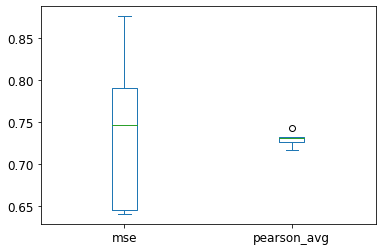

In [22]:
# plot spearman and pearson scores
metrics.iloc[:,1:].plot.box();

In [23]:
# Overall score for oof
_,_,corr_df= score_each(oof,df[target_col])

overall MSE: 0.7398
Average Pearson: 0.7300 


In [24]:
corr_df.sort_values('Pearson').head() # lowest Pearson

,Pearson
81,-0.243886
156,-0.238927
313,-0.197956
381,-0.151646
205,-0.081901


## XGB

In [25]:
#| export
def xgb_trainer(df,
                feature_col,
                target_col,
                split=None, # a tuple of two numpy for index
                xgb_params=None, # a dictionary of XGB params for xgb.train
                save=None, # model to be saved, e.g.,xgb_model.bin
                split_seed = 123, # seed of random split
               ):
    # assert len(target_col)==1, 'Only one target column is acceptable'
    
    X = df[feature_col]
    y = df[target_col]
    
    # Default XGBoost parameters if none provided
    if xgb_params is None:
        xgb_params = {
            'max_depth': 7,
            'learning_rate': 0.001,
            'subsample': 0.8,
            'colsample_bytree': 1,
            'eval_metric': 'rmse',
            'objective': 'reg:squarederror',
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
            'random_state': 123
        }
    
    
    if split is not None:
        train_idx, test_idx = split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_seed)

        
    print(X_train.shape,y_train.shape,X_test.shape, y_test.shape)
    print(y_test.index)
    #prepare matrix for xgb
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    
    model = xgb.train(xgb_params, 
            dtrain=dtrain,
            evals=[(dtrain,'train'),(dtest,'valid')],
            num_boost_round=9999,
            early_stopping_rounds=100,
            verbose_eval=100,)
    
        
    # Save model if requested
    if save is not None:
        path = Path(save)
        path.parent.mkdir(parents=True, exist_ok=True)  # Ensures directory exists
        model.save_model(save)
        print(f'Model saved to {save}')

    
    # Make predictions
    pred = model.predict(dtest)
    pred_df = pd.DataFrame({'target': y_test.values.squeeze(), 'pred': pred}, index=y_test.index)
    
    # Calculate and print correlations
    mse = mean_squared_error(pred_df.target, pred_df.pred)
    spearman_corr, _ = spearmanr(pred_df.target, pred_df.pred)
    pearson_corr, _ = pearsonr(pred_df.target, pred_df.pred)
    print(f'MSE: {mse:.4f}')
    print(f'Spearman correlation: {spearman_corr:.4f}')
    print(f'Pearson correlation: {pearson_corr:.4f}')

    
    # Extract feature importance for both gain and weight
    gain_importance = model.get_score(importance_type='gain')
    weight_importance = model.get_score(importance_type='weight')

    # Create a DataFrame from the gain and weight dictionaries
    feature_importance_df = pd.DataFrame({
        'feature': gain_importance.keys(),
        'gain_importance': gain_importance.values(),
        'weight_importance': [weight_importance.get(feature, 0) for feature in gain_importance.keys()]
    }).set_index('feature')

    # Sorting by gain importance for demonstration
    feature_importance_df = feature_importance_df.sort_values(by='gain_importance', ascending=False)

    
    return pred_df, feature_importance_df

In [26]:
from sklearn.datasets import make_regression

# Generate a dataset with 100 samples, 10 features, and a single target
X, y = make_regression(n_samples=100, n_features=10, noise=0.1, random_state=42)

# Convert the arrays to a DataFrame for easier handling
df_features = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df_target = pd.DataFrame(y, columns=['target'])

# Combine features and target into a single DataFrame
df2 = pd.concat([df_features, df_target], axis=1)

In [27]:
# _,_2 = xgb_trainer(df2,df2.columns[:-1],['target'],save='raw/xgb_model.bin')
_,_2 = xgb_trainer(df2,df2.columns[:-1],['target'])

(80, 10) (80, 1) (20, 10) (20, 1)
Int64Index([8, 70, 82, 28, 63, 0, 5, 50, 81, 4, 23, 65, 76, 60, 24, 42, 77, 38,
            56, 75],
           dtype='int64')
[0]	train-rmse:186.59671	valid-rmse:208.89759
[100]	train-rmse:173.74984	valid-rmse:199.68898
[200]	train-rmse:162.06862	valid-rmse:191.33017
[300]	train-rmse:151.17434	valid-rmse:184.08553
[400]	train-rmse:141.05164	valid-rmse:176.86816
[500]	train-rmse:131.71589	valid-rmse:170.50724
[600]	train-rmse:123.08520	valid-rmse:164.61815
[700]	train-rmse:114.95532	valid-rmse:159.13452
[800]	train-rmse:107.47933	valid-rmse:154.11130
[900]	train-rmse:100.46374	valid-rmse:149.70365
[1000]	train-rmse:94.00423	valid-rmse:145.58551
[1100]	train-rmse:87.95807	valid-rmse:142.02721
[1200]	train-rmse:82.29044	valid-rmse:138.69499
[1300]	train-rmse:77.05330	valid-rmse:135.53127
[1400]	train-rmse:72.13397	valid-rmse:132.72175
[1500]	train-rmse:67.57272	valid-rmse:130.21089
[1600]	train-rmse:63.22336	valid-rmse:127.85269
[1700]	train-rmse:59.2934

In [28]:
#| export
def xgb_predict(df, # a dataframe that contains ID and features for prediction
                feature_col, #feature column name
                model_file='xgb_model.bin'):
    # Load the XGBoost model
    model = xgb.Booster()
    model.load_model(model_file)
    
    # Prepare data for prediction
    X = df[feature_col]
    dtest = xgb.DMatrix(X)
    
    # Make predictions
    preds = model.predict(dtest)
    
    # Combine predictions with IDs into a DataFrame
    result_df = pd.DataFrame({'preds': preds})
    
    return result_df

In [29]:
xgb_predict(df2,df2.columns[:-1],'raw/xgb_model.bin')

,preds
0,-220.819397
1,416.755585
2,231.517639
3,-203.706909
4,-150.477249
...,...
95,-156.350845
96,-57.898319
97,196.047531
98,49.925449


In [30]:
#| hide
import nbdev; nbdev.nbdev_export()

In [31]:
# class XGBlearner:
#     def __init__(self,df,feat_col, target_col, split=None, params=None):
#         if params is None:
#             self.params = { 
#                             'max_depth':7, #from 4 to 7
#                             'learning_rate':0.001, #from 0.001
#                             'subsample':0.8,
#                             'colsample_bytree':1, # from 0.2 to 1, because need to take all features
#                             'eval_metric':'rmse',
#                             'objective':'reg:squarederror',
#                             'tree_method':'gpu_hist',
#                             'predictor':'gpu_predictor',
#                             'random_state':123
#                             }
#         else:
#             self.params = params
            
#         print(f'xgb params is: {self.params}')
            
#         X = df[feature_col]
#         y = df[target_col]

#         if split is None:
#             self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=123)
#         else:
#             self.X_train, self.y_train, self.X_test, self.y_test = split_data(df,feat_col,target_col,split)

#         print(self.X_train.shape,self.y_train.shape,self.X_test.shape, self.y_test.shape)
        
#         # prepare matrix for xgb
#         self.dtrain = xgb.DMatrix(X_train, y_train)
#         self.dtest = xgb.DMatrix(X_test, y_test)
        
    
#     def train(self,model_pth = None):
        
#         self.model = xgb.train(xgb_params, 
#                                dtrain=dtrain,
#                                evals=[(dtrain,'train'),(dtest,'valid')],
#                                num_boost_round=9999,
#                                early_stopping_rounds=100,
#                                verbose_eval=100,)
        
#         if model_pth is not None:
#             self.model.save_model(model_pth)
    
    
#     def valid(self, plot=True):
#         # Prepare the pred/target df
#         self.pred = self.model.predict(self.dtest)

#         out = np.vstack([np.ravel(self.y_test),np.ravel(self.pred)]).T
#         self.pred_df = pd.DataFrame(out,index=self.y_test.index, columns = ['target','pred'] )

#         spearman_corr, _ = spearmanr(self.pred_df.target, self.pred_df.pred)
#         print(f'Spearman correlation: {spearman_corr:.2f}')
#         pearson_corr, p_value = pearsonr(self.pred_df.target, self.pred_df.pred)
#         print(f'Pearson correlation: {pearson_corr:.2f}')
        
#         if plot:
#             fig, ax = plt.subplots()
#             ax.scatter(self.pred_df.target, self.pred_df.pred)
#             ax.set_xlabel('True values')
#             ax.set_ylabel('Predicted values')
#             ax.set_title('Scatter plot of true versus predicted values')
#             plt.show()
#             plt.close()
        
#     def plot_importance(self):
#         dd = self.model.get_score(importance_type='gain')
#         self.gain = pd.DataFrame({'feature':dd.keys(),f'gain_importance':dd.values()}).set_index('feature').sort_values(by='gain_importance',ascending=False)
#         self.gain[:10].plot.barh()
#         plt.show()
#         plt.close()

#         dd = self.model.get_score(importance_type='weight')
#         self.weight = pd.DataFrame({'feature':dd.keys(),f'weight_importance':dd.values()}).set_index('feature').sort_values(by='weight_importance',ascending=False)
#         self.weight[:10].plot.barh()
#         plt.show()
#         plt.close()
        